In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ============================================================
# 6️⃣ AUTOMATIC INTERPRETATION
# ============================================================

def interpret(target):
    r2_tlx  = results_df[(results_df.Target == target) & (results_df.Model == "TLX_only")]['R2'].values[0]
    r2_bio  = results_df[(results_df.Target == target) & (results_df.Model == "Biosignals_only")]['R2'].values[0]

    print("\n--------------------------------------------------")
    print(f"AUTOMATIC INTERPRETATION FOR: {target.upper()}")
    print("--------------------------------------------------")

    if r2_tlx > 0.8 and r2_bio < 0.3:
        print(f"➡ {target.capitalize()} is mainly explained by **TLX questionnaire**.")
        print("➡ Biosignals contribute very little → label not physiological.")
    elif r2_bio > r2_tlx:
        print(f"➡ {target.capitalize()} is mainly driven by **physiological signals**.")
    elif r2_bio < 0.1:
        print(f"➡ Biosignals fail → label noisy or inconsistent across subjects.")
    else:
        print(f"➡ Mixed signal: TLX + biosignals both contribute.")


for target in targets:
    interpret(target)


--------------------------------------------------
AUTOMATIC INTERPRETATION FOR: FATIGUE
--------------------------------------------------
➡ Fatigue is mainly explained by **TLX questionnaire**.
➡ Biosignals contribute very little → label not physiological.

--------------------------------------------------
AUTOMATIC INTERPRETATION FOR: STRESS
--------------------------------------------------
➡ Stress is mainly explained by **TLX questionnaire**.
➡ Biosignals contribute very little → label not physiological.

--------------------------------------------------
AUTOMATIC INTERPRETATION FOR: FOCUS
--------------------------------------------------
➡ Focus is mainly explained by **TLX questionnaire**.
➡ Biosignals contribute very little → label not physiological.


In [58]:
# ==========================
# 1️⃣ Imports
# ==========================
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ==========================
# 2️⃣ Load dataset
# ==========================
train_path = "/content/drive/MyDrive/universe_ml/train/train_dataset.csv"
test_path  = "/content/drive/MyDrive/universe_ml/test/test_dataset.csv"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

# ==========================
# 3️⃣ Select only EEG, HRV, Temperature features + labels
# ==========================
ml_columns = [
    # EEG features
    'mean_δ','mean_θ','mean_α','mean_β','mean_γ',
    'α/θ','θ/α','frontal_α_asy','δ_asy','θ_asy','α_asy','β_asy','γ_asy',
    # HRV
    'HRV_MeanNN','HRV_SDNN','HRV_RMSSD','HRV_LFn','HRV_HFn','HRV_ratio_LFn_HFn',
    # Temperature
    'mean_temp','std_temp',
    # Labels
    'fatigue','stress','focus'
]

# Keep only these columns
train_df = train_df[[c for c in ml_columns if c in train_df.columns]]
test_df  = test_df[[c for c in ml_columns if c in test_df.columns]]

# Features and labels
X_train = train_df[[c for c in ml_columns if c not in ['fatigue','stress','focus']]]
y_train = train_df[['fatigue','stress','focus']]

X_test = test_df[[c for c in ml_columns if c not in ['fatigue','stress','focus']]]
y_test = test_df[['fatigue','stress','focus']]

# ==========================
# 4️⃣ Standardize features
# ==========================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ==========================
# 5️⃣ Train MultiOutput Random Forest
# ==========================
model = MultiOutputRegressor(
    RandomForestRegressor(n_estimators=300, max_depth=12, random_state=42)
)
model.fit(X_train_scaled, y_train)

# ==========================
# 6️⃣ Evaluate model
# ==========================
y_pred = model.predict(X_test_scaled)

print("\n========================= MODEL EVALUATION =========================")
for i, col in enumerate(y_train.columns):
    rmse = np.sqrt(mean_squared_error(y_test[col], y_pred[:, i]))
    r2   = r2_score(y_test[col], y_pred[:, i])
    print(f"{col} → RMSE: {rmse:.3f}, R²: {r2:.3f}")

# ==========================
# 7️⃣ Feature importance
# ==========================
feature_names = X_train.columns

for i, col in enumerate(y_train.columns):
    importances = model.estimators_[i].feature_importances_
    sorted_idx = np.argsort(importances)[::-1]

    print(f"\nTop features for {col}:")
    for f, imp in zip(feature_names[sorted_idx], importances[sorted_idx]):
        print(f"{f}: {imp:.4f}")



========================= MODEL EVALUATION =========================
fatigue → RMSE: 29.375, R²: 0.031
stress → RMSE: 1.527, R²: 0.041
focus → RMSE: 1.583, R²: 0.049

Top features for fatigue:
mean_temp: 0.1932
std_temp: 0.1418
mean_γ: 0.0672
α_asy: 0.0502
β_asy: 0.0459
HRV_MeanNN: 0.0450
mean_θ: 0.0400
mean_δ: 0.0385
θ_asy: 0.0377
HRV_SDNN: 0.0361
mean_β: 0.0360
δ_asy: 0.0357
γ_asy: 0.0355
frontal_α_asy: 0.0350
mean_α: 0.0314
HRV_LFn: 0.0312
HRV_HFn: 0.0274
HRV_RMSSD: 0.0238
θ/α: 0.0168
HRV_ratio_LFn_HFn: 0.0158
α/θ: 0.0155

Top features for stress:
mean_temp: 0.1979
std_temp: 0.1250
mean_δ: 0.0644
α_asy: 0.0512
θ_asy: 0.0482
HRV_MeanNN: 0.0457
mean_α: 0.0449
frontal_α_asy: 0.0447
HRV_SDNN: 0.0439
β_asy: 0.0363
γ_asy: 0.0340
mean_β: 0.0331
HRV_RMSSD: 0.0327
mean_γ: 0.0318
mean_θ: 0.0311
HRV_HFn: 0.0290
δ_asy: 0.0237
HRV_LFn: 0.0223
HRV_ratio_LFn_HFn: 0.0221
α/θ: 0.0191
θ/α: 0.0190

Top features for focus:
mean_temp: 0.2070
std_temp: 0.1315
mean_δ: 0.0598
α_asy: 0.0530
HRV_MeanNN: 0.0

In [59]:
# ==========================
# 6️⃣ Evaluate model (with tolerance-based accuracy)
# ==========================
tolerance = 0.1  # e.g., consider prediction correct if within ±0.1 of true value

y_pred = model.predict(X_test_scaled)

print("\n========================= MODEL EVALUATION =========================")
for i, col in enumerate(y_train.columns):
    rmse = np.sqrt(mean_squared_error(y_test[col], y_pred[:, i]))
    r2   = r2_score(y_test[col], y_pred[:, i])

    # Tolerance-based accuracy
    correct = np.abs(y_test[col] - y_pred[:, i]) <= tolerance
    acc = np.mean(correct) * 100  # percentage

    print(f"{col} → RMSE: {rmse:.3f}, R²: {r2:.3f}, Accuracy (±{tolerance}): {acc:.2f}%")



========================= MODEL EVALUATION =========================
fatigue → RMSE: 29.375, R²: 0.031, Accuracy (±0.1): 2.10%
stress → RMSE: 1.527, R²: 0.041, Accuracy (±0.1): 16.67%
focus → RMSE: 1.583, R²: 0.049, Accuracy (±0.1): 15.26%


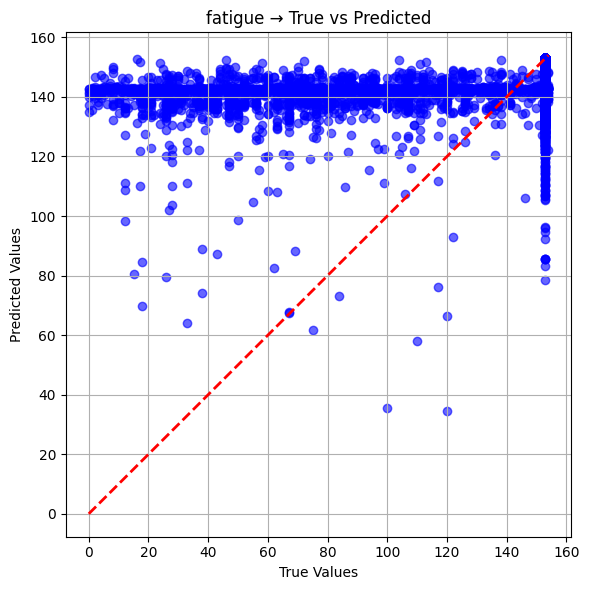

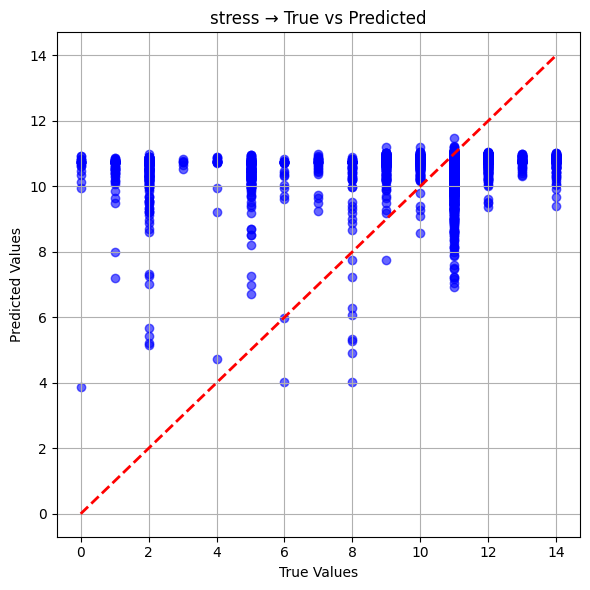

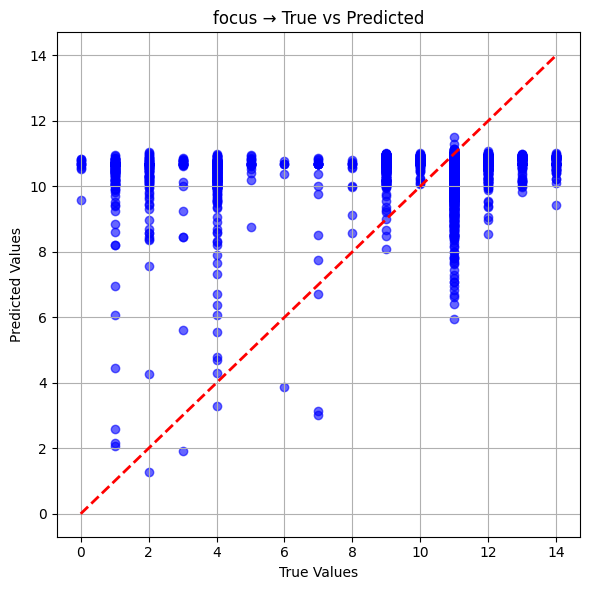

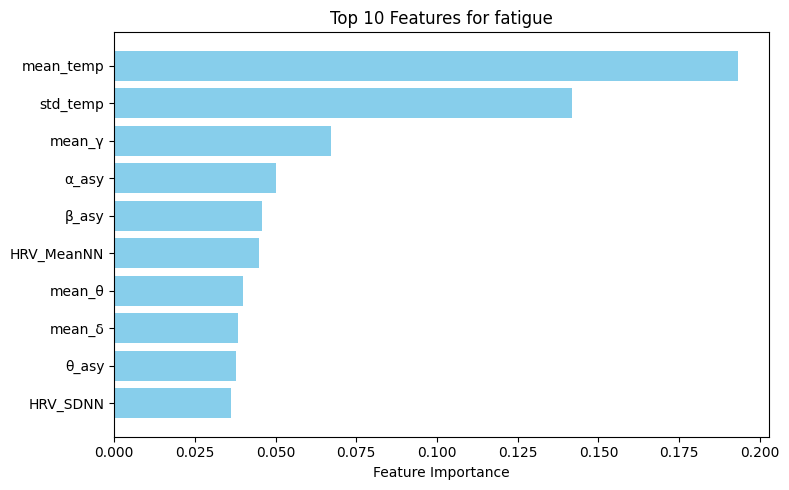

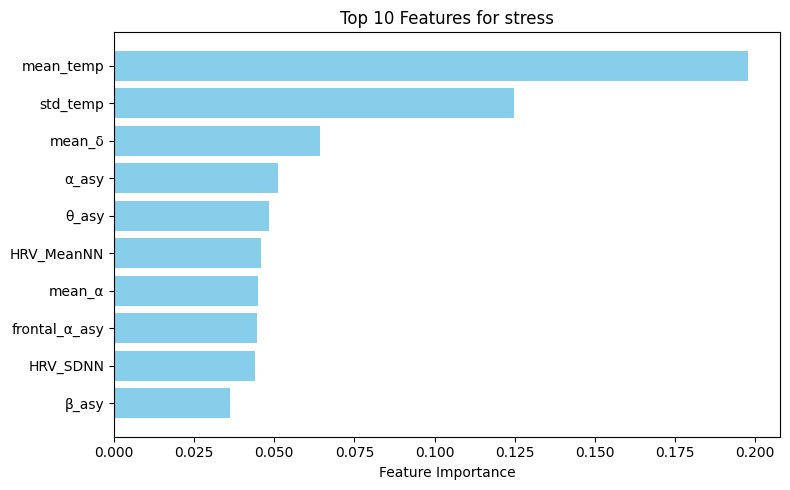

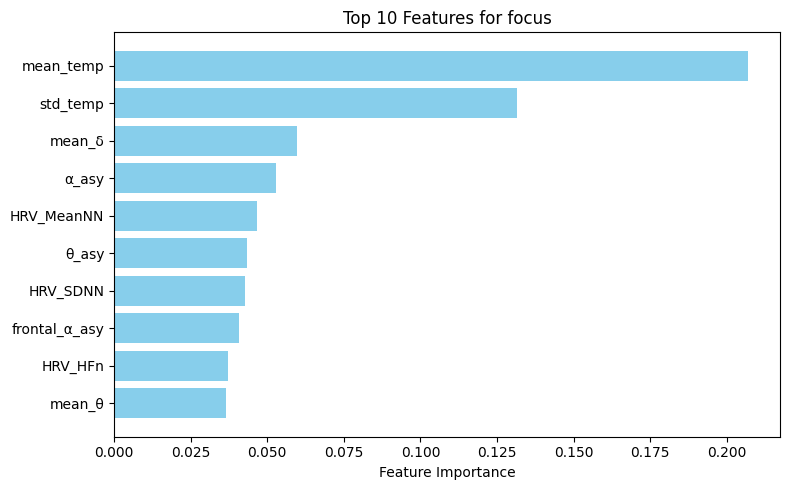

In [60]:
import matplotlib.pyplot as plt

# ==========================
# Graph 1️⃣ : y_true vs y_pred
# ==========================
for i, col in enumerate(y_train.columns):
    plt.figure(figsize=(6,6))
    plt.scatter(y_test[col], y_pred[:, i], alpha=0.6, color='blue')
    plt.plot([y_test[col].min(), y_test[col].max()],
             [y_test[col].min(), y_test[col].max()],
             'r--', lw=2)
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{col} → True vs Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ==========================
# Graph 2️⃣ : Top 10 features importance
# ==========================
for i, col in enumerate(y_train.columns):
    importances = model.estimators_[i].feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    top_features = feature_names[sorted_idx][:10]
    top_importances = importances[sorted_idx][:10]

    plt.figure(figsize=(8,5))
    plt.barh(top_features[::-1], top_importances[::-1], color='skyblue')
    plt.xlabel("Feature Importance")
    plt.title(f"Top 10 Features for {col}")
    plt.tight_layout()
    plt.show()
